# BERT's Attention and Dependency Syntax

This notebook contains code for comparing BERT's attention to dependency syntax annotations (see Sections 4.2 and 5 of [What Does BERT Look At? An Analysis of BERT's Attention](https://arxiv.org/abs/1906.04341))

In [1]:
import collections
import pickle
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


### Loading the data

Download the data used in this notebook from [here](https://drive.google.com/open?id=1DEIBQIl0Q0az5ZuLoy4_lYabIfLSKBg-). However, note that since Penn Treebank annotations are not public, this is dummy data where all labels are ROOT. See the README for extracting attention maps on your own data.

In [2]:
def load_pickle(fname):
  with open(fname, "rb") as f:
    dev_data =  pickle.load(f, encoding="latin1")  # add, encoding="latin1") if using python3 and downloaded data
    return (dev_data)
    
dev_data = load_pickle("./data/ud/ud_attention_data.pkl")


# The data consists of a list of examples (dicts)
# with the following keys/values
# {
#    "words": list of words in the sentence
#    "heads": index of each word"s syntactic head (0 for ROOT, 1 for the first 
#             word of the sentence, etc.)
#    "relns": the relation between each word and its head
#    "attns": [n_layers, n_heads, seq_len, seq_len] tensor of attention maps
#             from BERT
#}
index=5
print("words:", dev_data[index]["words"])
print("heads:", dev_data[index]["heads"])
print("relns:", dev_data[index]["relns"])
# Attention maps are 9x9 because [CLS] and [SEP] are added
print("attns: a tensor with shape", dev_data[index]["attns"].shape)

words: ['This', 'item', 'is', 'a', 'small', 'one', 'and', 'easily', 'missed', '.']
heads: [2 6 6 6 6 0 9 9 6 6]
relns: ['det', 'nsubj', 'cop', 'det', 'amod', 'root', 'cc', 'advmod', 'conj', 'punct']
attns: a tensor with shape torch.Size([12, 12, 12, 12])


In [3]:
# Find the most common relations in our data
reln_counts = collections.Counter()
for example in dev_data:
  for reln in example["relns"]:
    reln_counts[reln] += 1
print(reln_counts.most_common(10))

[('punct', 5737), ('nsubj', 4342), ('root', 4211), ('det', 3769), ('case', 3688), ('advmod', 2803), ('obj', 2734), ('obl', 2137), ('amod', 1999), ('mark', 1868)]


### Evaluating individual heads at dependency syntax (Section 4.2)

In [4]:
# Code for evaluating individual attention maps and baselines

def evaluate_predictor(prediction_fn):
  """Compute accuracies for each relation for the given predictor."""
  n_correct, n_incorrect = collections.Counter(), collections.Counter()
  for example in dev_data:
    words = example["words"]
    predictions = prediction_fn(example)
    for i, (p, y, r) in enumerate(zip(predictions, example["heads"],
                                      example["relns"])):
      is_correct = (p == y)
      if r == "poss" and p < len(words):
        # Special case for poss (see discussion in Section 4.2)
        if i < len(words) and words[i + 1] == "'s" or words[i + 1] == "s'":
          is_correct = (predictions[i + 1] == y)
      if is_correct:
        n_correct[r] += 1
        n_correct["all"] += 1
      else:
        n_incorrect[r] += 1
        n_incorrect["all"] += 1
  return {k: n_correct[k] / float(n_correct[k] + n_incorrect[k])
          for k in n_incorrect.keys()}

def attn_head_predictor(layer, head, mode="normal"):
  """Assign each word the most-attended-to other word as its head."""
  def predict(example):
    attn = np.array(example["attns"][layer][head])
    if mode == "transpose":
      attn = attn.T
    elif mode == "both":
      attn += attn.T
    else:
      assert mode == "normal"
    # ignore attention to self and [CLS]/[SEP] tokens
    attn[range(attn.shape[0]), range(attn.shape[0])] = 0
    attn = attn[1:-1, 1:-1]
    return np.argmax(attn, axis=-1) + 1  # +1 because ROOT is at index 0
  return predict

def offset_predictor(offset):
  """Simple baseline: assign each word the word a fixed offset from
  it (e.g., the word to its right) as its head."""
  def predict(example):
    return [max(0, min(i + offset + 1, len(example["words"])))
            for i in range(len(example["words"]))]
  return predict

def get_scores(mode="normal"):
  """Get the accuracies of every attention head."""
  scores = collections.defaultdict(dict)
  for layer in range(12):
    for head in range(12):
      scores[layer][head] = evaluate_predictor(
          attn_head_predictor(layer, head, mode))
  return scores

# attn_head_scores[direction][layer][head][dep_relation] = accuracy
attn_head_scores = {
    "dep->head": get_scores("normal"),
    "head<-dep": get_scores("transpose")
}
# baseline_scores[offset][dep_relation] = accuracy
baseline_scores = {
    i: evaluate_predictor(offset_predictor(i)) for i in range(-3, 3)
}

In [5]:
def get_all_scores(reln):
  """Get all attention head scores for a particular relation."""
  all_scores = []
  for key, layer_head_scores in attn_head_scores.items():
    for layer, head_scores in layer_head_scores.items():
      for head, scores in head_scores.items():
        all_scores.append((scores[reln], layer, head, key))
  return sorted(all_scores, reverse=True)

In [6]:
# Compare the best attention head to baselines across the most common relations.
# This produces the scores in Table 1
for row, (reln, _) in enumerate([("all", 0)] + reln_counts.most_common()):
  if reln == "root" or reln == "punct":
    continue
  if reln_counts[reln] < 100 and reln != "all":
    break

  uas, layer, head, direction = sorted(
      s for s in get_all_scores(reln))[-1]
  baseline_uas, baseline_offset = max(
      (scores[reln], i) for i, scores in baseline_scores.items())
  print("{:8s} | {:5d} | attn: {:.1f} | offset={:2d}: {:.1f} | {:}-{:} {:}".format(
      reln[:8], reln_counts[reln], 100 * uas, baseline_offset, 100 * baseline_uas,
      layer, head, direction))

all      |     0 | attn: 42.8 | offset= 1: 29.3 | 6-4 dep->head
nsubj    |  4342 | attn: 65.6 | offset= 1: 42.3 | 6-7 dep->head
det      |  3769 | attn: 93.3 | offset= 1: 63.3 | 6-4 dep->head
case     |  3688 | attn: 88.5 | offset= 2: 39.3 | 6-4 dep->head
advmod   |  2803 | attn: 60.0 | offset= 1: 46.8 | 5-6 dep->head
obj      |  2734 | attn: 81.4 | offset=-1: 36.2 | 5-7 dep->head
obl      |  2137 | attn: 30.2 | offset=-3: 22.1 | 7-8 dep->head
amod     |  1999 | attn: 80.9 | offset= 1: 78.1 | 10-6 head<-dep
mark     |  1868 | attn: 70.4 | offset= 1: 51.5 | 6-8 dep->head
aux      |  1659 | attn: 76.4 | offset= 1: 50.2 | 6-4 dep->head
conj     |  1574 | attn: 49.2 | offset=-2: 27.6 | 11-11 head<-dep
cc       |  1539 | attn: 63.1 | offset= 1: 46.9 | 6-4 dep->head
nmod     |  1353 | attn: 37.0 | offset=-2: 38.2 | 1-7 dep->head
compound |  1257 | attn: 87.8 | offset= 1: 84.9 | 6-10 dep->head
cop      |  1134 | attn: 81.3 | offset= 1: 36.8 | 6-4 dep->head
advcl    |   926 | attn: 28.2 | offs

In [7]:
# Results are not as expected, check http://corpling.uis.georgetown.edu/gum/, 
# and https://github.com/amir-zeldes/gum/tree/master/dep

### Qualitative examples of attention (Figure 5)

In [7]:
def plot_attn(title, examples, layer, head, color_words,
              color_from=True, width=3, example_sep=3, 
              word_height=1, pad=0.1, hide_sep=False):
  """Plot BERT's attention for a particular head/example."""
  plt.figure(figsize=(4, 4))
  for i, example in enumerate(examples):
    yoffset = 0
    if i == 0:
      yoffset += (len(examples[0]["words"]) -
                  len(examples[1]["words"])) * word_height / 2
    xoffset = i * width * example_sep
    attn = example["attns"][layer][head]
    attn = np.array(attn)
    if hide_sep:
      attn[:, 0] = 0
      attn[:, -1] = 0
      attn /= attn.sum(axis=-1, keepdims=True)

    words = ["[CLS]"] + example["words"] + ["[SEP]"]
    n_words = len(words)
    for position, word in enumerate(words):
      for x, from_word in [(xoffset, True), (xoffset + width, False)]:
        color = "k"
        if from_word == color_from and word in color_words:
          color = "#cc0000"
        plt.text(x, yoffset - (position * word_height), word,
                 ha="right" if from_word else "left", va="center",
                 color=color)

    for i in range(n_words):
      for j in range(n_words):
        color = "b"
        if words[i if color_from else j] in color_words:
          color = "r"
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color=color, linewidth=1, alpha=attn[i, j])
  plt.axis("off")
  plt.title(title)
  plt.show()


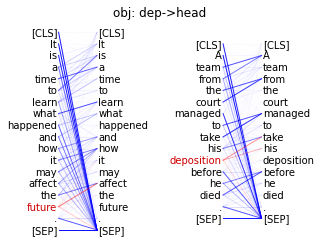

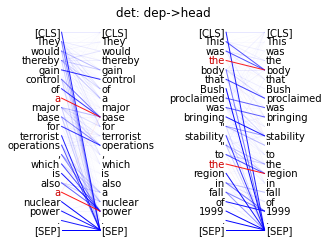

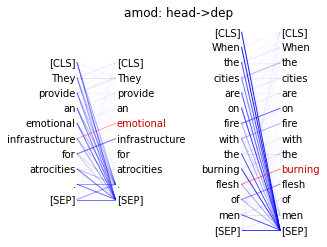

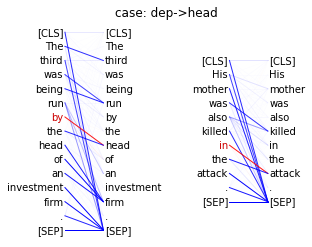

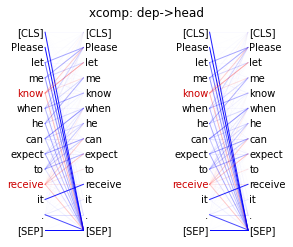

In [8]:
# Examples similar to Figure 5 of the paper.
plot_attn("obj: dep->head", [dev_data[12], dev_data[8]], 5, 7, 
          ["future", "deposition"], example_sep=4)

plot_attn("det: dep->head", [dev_data[20], dev_data[31]], 6, 4, 
          ["a", "the"], example_sep=4)

plot_attn("amod: head->dep", [dev_data[294], dev_data[173]], 10, 6, 
          ["emotional", "burning"], example_sep=4, color_from=False)

plot_attn("case: dep->head", [dev_data[1], dev_data[3]], 6, 4, 
          ["by", "in"], example_sep=4)

plot_attn("xcomp: dep->head", [dev_data[852], dev_data[852]], 5, 7, 
          ["know", "receive"], example_sep=4)

### Probing classifiers (Section 5)

In [9]:
class WordEmbeddings(object):
  """Class for loading/using pretrained GloVe embeddings"""
    
  def __init__(self):
    self.pretrained_embeddings = load_pickle("./data/glove/embeddings.pkl")
    self.vocab = load_pickle("./data/glove/vocab.pkl")

  def tokid(self, w):
    return self.vocab.get(w.lower(), 0)

In [10]:
N_DISTANCE_FEATURES = 8
def make_distance_features(seq_len):
  """Constructs distance features for a sentence."""
  # how much ahead/behind the other word is
  distances = np.zeros((seq_len, seq_len))
  for i in range(seq_len):
    for j in range(seq_len):
      if i < j:
        distances[i, j] = (j - i) / float(seq_len)
  feature_matrices = [distances, distances.T]

  # indicator features on if other word is up to 2 words ahead/behind
  for k in range(3):
    for direction in ([1] if k == 0 else [-1, 1]):
      feature_matrices.append(np.eye(seq_len, k=k*direction))
  features = np.stack(feature_matrices)

  # additional indicator feature for ROOT
  features = np.concatenate(
      [np.zeros([N_DISTANCE_FEATURES - 1, seq_len, 1]), 
       features], -1)
  root = np.zeros((1, seq_len, seq_len + 1))
  root[:, :, 0] = 1

  return np.concatenate([features, root], 0)

In [11]:
def attn_linear_combo():
  return Probe()


def attn_and_words():
  return Probe(use_words=True)


def words_and_distances():
  return Probe(use_distance_features=True, use_attns=False,
               use_words=True, hidden_layer=True)


class Probe(object):
  """The probing classifier used in Section 5."""

  def __init__(self, use_distance_features=False, use_words=False,
               use_attns=True, include_transpose=True, hidden_layer=False):
    self._embeddings = WordEmbeddings()

    # We use a simple model with batch size 1
    self._attns = tf.placeholder(
        shape=[12, 12, None, None], dtype=tf.float32)
    self._labels = tf.placeholder(
        shape=[None], dtype=tf.int32)
    self._features = tf.placeholder(
        shape=[N_DISTANCE_FEATURES, None, None], dtype=tf.float32)
    self._words = tf.placeholder(shape=[None], dtype=tf.int32)

    if use_attns:
      seq_len = tf.shape(self._attns)[-1]
      if include_transpose:
        # Include both directions of attention
        attn_maps = tf.concat(
            [self._attns,
             tf.transpose(self._attns, [0, 1, 3, 2])], 0)
        attn_maps = tf.reshape(attn_maps, [288, seq_len, seq_len])
      else:
        attn_maps = tf.reshape(self._attns, [144, seq_len, seq_len])
      # Use attention to start/end tokens to get score for ROOT
      root_features = (
          (tf.get_variable("ROOT_start", shape=[]) * attn_maps[:, 1:-1, 0]) +
          (tf.get_variable("ROOT_end", shape=[]) * attn_maps[:, 1:-1, -1])
      )
      attn_maps = tf.concat([tf.expand_dims(root_features, -1),
                             attn_maps[:, 1:-1, 1:-1]], -1)
    else:
      # Dummy attention map for models not using attention inputs
      n_words = tf.shape(self._words)[0]
      attn_maps = tf.zeros((1, n_words, n_words + 1))

    if use_distance_features:
      attn_maps = tf.concat([attn_maps, self._features], 0)

    if use_words:
      word_embedding_matrix = tf.get_variable(
          "word_embedding_matrix",
          initializer=self._embeddings.pretrained_embeddings,
          trainable=False)
      word_embeddings = tf.nn.embedding_lookup(word_embedding_matrix, self._words)
      n_words = tf.shape(self._words)[0]
      tiled_vertical = tf.tile(tf.expand_dims(word_embeddings, 0),
                               [n_words, 1, 1])
      tiled_horizontal = tf.tile(tf.expand_dims(word_embeddings, 1),
                                 [1, n_words, 1])
      word_reprs = tf.concat([tiled_horizontal, tiled_vertical], -1)
      word_reprs = tf.concat([word_reprs, tf.zeros((n_words, 1, 200))], 1) # dummy for ROOT
      if not use_attns:
        attn_maps = tf.concat([
            attn_maps, tf.transpose(word_reprs, [2, 0, 1])], 0)

    attn_maps = tf.transpose(attn_maps, [1, 2, 0])
    if use_words and use_attns:
      # attention-and-words probe
      weights = tf.layers.dense(word_reprs, attn_maps.shape[-1])
      self._logits = tf.reduce_sum(weights * attn_maps, axis=-1)
    else:
      if hidden_layer:
        # 1-hidden-layer MLP for words-and-distances baseline
        attn_maps = tf.layers.dense(attn_maps, 256,
                                    activation=tf.nn.tanh)
        self._logits = tf.squeeze(tf.layers.dense(attn_maps, 1), -1)
      else:
        # linear combination of attention heads
        attn_map_weights = tf.get_variable("attn_map_weights",
                                           shape=[attn_maps.shape[-1]])
        self._logits = tf.reduce_sum(attn_map_weights * attn_maps, axis=-1)

    loss = tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=self._logits, labels=self._labels))
    opt = tf.train.AdamOptimizer(learning_rate=0.002)
    self._train_op = opt.minimize(loss)

  def _create_feed_dict(self, example):
    return {
        self._attns: example["attns"],
        self._labels: example["heads"],
        self._features: make_distance_features(len(example["words"])),
        self._words: [self._embeddings.tokid(w) for w in example["words"]]
    }

  def train(self, sess, example):
    return sess.run(self._train_op, feed_dict=self._create_feed_dict(example))

  def test(self, sess, example):
    return sess.run(self._logits, feed_dict=self._create_feed_dict(example))


def run_training(probe, train_data, dev_data):
  """Trains and evaluates the given attention probe."""
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(1):
      print(40 * "=")
      print("EPOCH", (epoch + 1))
      print(40 * "=")
      print("Training...")
      for i, example in enumerate(train_data):
        if i % 1000 == 0:
          print("{:}/{:}".format(i, len(train_data)))
        probe.train(sess, example)

      print("Evaluating...")
      correct, total = 0, 0
      for i, example in enumerate(dev_data):
        if i % 1000 == 0:
          print("{:}/{:}".format(i, len(dev_data)))
        logits = probe.test(sess, example)
        for i, (head, prediction, reln) in enumerate(
            zip(example["heads"], logits.argmax(-1), example["relns"])):
          # it is standard to ignore punct for Stanford Dependency evaluation
          if reln != "punct":
            if head == prediction:
              correct += 1
            total += 1
      print("UAS: {:.1f}".format(100 * correct / total))

In [12]:
tf.reset_default_graph()
attention_data = load_pickle("./data/ud/ud_attention_data.pkl")
train_samples = round(0.8*len(attention_data))
train_data = attention_data[:train_samples]
dev_data = attention_data[train_samples:]
run_training(attn_and_words(), train_data, dev_data)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
EPOCH 1
Training...
0/3369
1000/3369
2000/3369
3000/3369
Evaluating...
0/842
UAS: 71.5


In [13]:
tf.reset_default_graph()